## Assignment 1

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib as plt
import datetime as dt

In [2]:
url = 'Ruter_data.csv'
df = pd.read_csv(url, sep=';')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 17 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   TurId                                      6000 non-null   object
 1   Dato                                       6000 non-null   object
 2   Fylke                                      6000 non-null   object
 3   Område                                     6000 non-null   object
 4   Kommune                                    6000 non-null   object
 5   Holdeplass_Fra                             6000 non-null   object
 6   Holdeplass_Til                             6000 non-null   object
 7   Linjetype                                  6000 non-null   object
 8   Linjefylke                                 6000 non-null   object
 9   Linjenavn                                  6000 non-null   object
 10  Linjeretning                        

### Cleaning the data

In [4]:
df['Dato'] = pd.to_datetime(df['Dato'])

Når man prøver å konvertere tidspunktene til datetime så får man error. Fant ut at da at det er kolonner med timeverdier på 24 og 25. I tillegg noen med verdien : Lager en funksjon for å rydde opp i disse:

In [5]:
def toTimestamp(rowTitle):
    for index, row in df.iterrows():
        try:
            hour = int(row[rowTitle][:2])
        except:
            df.at[index, rowTitle] = np.nan
            hour = np.nan

        if hour == 24:
            # Endrer verdien i cellen til 00
            df.at[index, rowTitle] = "00"+row[rowTitle][2:]
        elif hour == 25:
            df.at[index, rowTitle] = "01"+row[rowTitle][2:]
        elif hour > 25:
            print(row[rowTitle])
            
    df[rowTitle] = pd.to_datetime(df[rowTitle],format= '%H:%M:%S' ).dt.time
        
toTimestamp('Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra')
toTimestamp('Tidspunkt_Faktisk_Avgang_Holdeplass_Fra')
toTimestamp('Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra')
toTimestamp('Tidspunkt_Planlagt_Avgang_Holdeplass_Fra')

Fjerne negative "Passasjerer_Ombord" verdier

In [8]:
    for index, row in df.iterrows():
        if df.at[index, 'Passasjerer_Ombord'] < 0:
            df.at[index, 'Passasjerer_Ombord'] = 0

## Features

#### 1. Kapasitet Prosent
Hvor mange prosent full en buss er

In [9]:
df["Kapasitet_Prosent"] = df['Passasjerer_Ombord']/df['Kjøretøy_Kapasitet']*100

#### 2. Ukedager
Hvilken ukedag datoen er på

In [11]:
df['Ukedag'] = df['Dato'].dt.day_name()

#### 3. Prosesstid
Tid brukt på stasjonen

In [15]:
df['Prosesstid'] = pd.to_datetime(df['Tidspunkt_Faktisk_Avgang_Holdeplass_Fra'], format='%H:%M:%S') - pd.to_datetime(df['Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra'], format='%H:%M:%S')
df['Prosesstid'] = df['Prosesstid'].dt.total_seconds()

#### 4. Forsinkelse
Hvor forsinket en buss avgang er

In [16]:
df['Forsinkelse'] = pd.to_datetime(df['Tidspunkt_Faktisk_Avgang_Holdeplass_Fra'], format='%H:%M:%S') - pd.to_datetime(df['Tidspunkt_Planlagt_Avgang_Holdeplass_Fra'], format='%H:%M:%S')
df['Forsinkelse'] = df['Forsinkelse'].dt.total_seconds()

In [19]:
# Fjerne store verdier som er støy
for index, row in df.iterrows():
    if df.at[index, 'Forsinkelse'] > 5000:
         df.at[index, 'Forsinkelse'] = np.nan
    elif df.at[index, 'Forsinkelse'] < -5000:
         df.at[index, 'Forsinkelse'] = np.nan

#### 5. Periode på døgnet
Hvilken periode buss avgangen er. Morgen, Kveld, etc...

In [20]:
df['Døgn_Periode'] = pd.to_datetime(df['Tidspunkt_Faktisk_Avgang_Holdeplass_Fra'], format='%H:%M:%S')
df['Døgn_Periode'] = df['Døgn_Periode'].dt.hour

conditions = [
    (df['Døgn_Periode'] <= 6),
    (df['Døgn_Periode'] > 6) & (df['Døgn_Periode'] <= 12),
    (df['Døgn_Periode'] > 12) & (df['Døgn_Periode'] <= 18),
    (df['Døgn_Periode'] > 18)
    ]
values = ['Natt', 'Morgen', 'Ettermiddag', 'Kveld']
df['tid_døgn'] = np.select(conditions, values)
df.head()

,TurId,Dato,Fylke,Område,Kommune,Holdeplass_Fra,Holdeplass_Til,Linjetype,Linjefylke,Linjenavn,...,Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra,Tidspunkt_Planlagt_Avgang_Holdeplass_Fra,Kjøretøy_Kapasitet,Passasjerer_Ombord,Kapasitet_Prosent,Ukedag,Prosesstid,Forsinkelse,Døgn_Periode,tid_døgn
0,15006-2020-08-10T10:24:00+02:00,2020-10-08,Viken,Vest,Bærum,Nordliveien,Tjernsmyr,Lokal,Viken,150,...,10:53:00,10:53:00,112,5,4.464286,Thursday,6.0,59.0,10.0,Morgen
1,15002-2020-08-15T12:54:00+02:00,2020-08-15,Viken,Vest,Bærum,Nadderud stadion,Bekkestua bussterminal (Plattform C),Lokal,Viken,150,...,13:12:00,13:12:00,112,5,4.464286,Saturday,6.0,26.0,13.0,Ettermiddag
2,15004-2020-08-03T09:54:00+02:00,2020-03-08,Viken,Vest,Bærum,Ringstabekkveien,Skallum,Lokal,Viken,150,...,10:19:00,10:19:00,112,6,5.357143,Sunday,25.0,21.0,10.0,Morgen
3,15003-2020-07-27T13:00:00+02:00,2020-07-27,Viken,Vest,Bærum,Gruvemyra,Gullhaug,Lokal,Viken,150,...,13:51:00,13:51:00,112,10,8.928571,Monday,22.0,86.0,13.0,Ettermiddag
4,15002-2020-08-27T07:15:00+02:00,2020-08-27,Viken,Vest,Bærum,Lysaker stasjon (Plattform A),Tjernsmyr,Lokal,Viken,150,...,07:33:00,07:33:00,112,10,8.928571,Thursday,40.0,113.0,7.0,Morgen


### Feature Engineering

#### 1. Prosesstid per dato

<AxesSubplot:xlabel='Prosesstid', ylabel='Dato'>

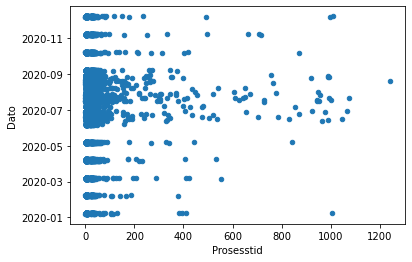

In [21]:
df.plot.scatter(x = 'Prosesstid', y = 'Dato')

#### 2. Antall busser per  døgn tid

<AxesSubplot:xlabel='tid_døgn'>

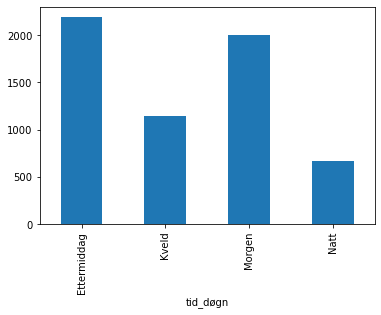

In [24]:
df_tidCount = df.groupby('tid_døgn').count()
df_tidCount["Døgn_Periode"].drop(["0"]).plot.bar()

#### 3. Fyllt kapasitet per time

<AxesSubplot:xlabel='Døgn_Periode', ylabel='Kapasitet_Prosent'>

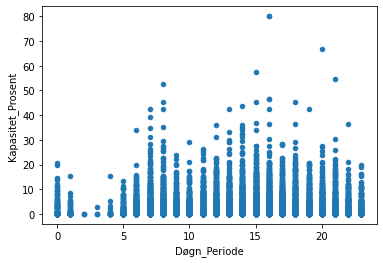

In [25]:
df.plot.scatter(x='Døgn_Periode', y='Kapasitet_Prosent')

#### 4. Antall busser per ukedag

<AxesSubplot:xlabel='Ukedag'>

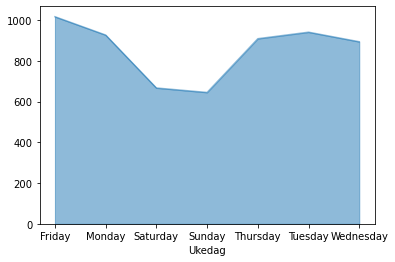

In [26]:
df_DagCount = df.groupby('Ukedag').count()
df_DagCount.Dato
df_DagCount["Dato"].plot.area(stacked=False)

#### 5. Forsinkelse per tid_døgn

<AxesSubplot:xlabel='Forsinkelse', ylabel='tid_døgn'>

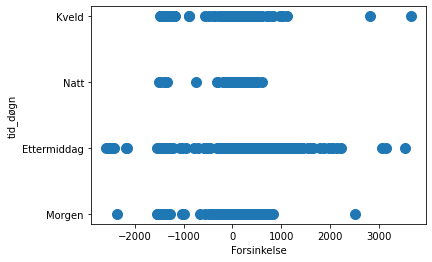

In [27]:
df.plot.scatter(x = 'Forsinkelse', y = 'tid_døgn', s = 100)